<a href="https://colab.research.google.com/github/leoquiroa/TimeSeries/blob/master/Prophet/By_Month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# time series algorithm
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics

from datetime import date
import holidays

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()

# Methods


In [0]:
def read_raw_csv(url,nrows):
  df_doc = pd.read_csv(
      url, 
      nrows=nrows,
      names = ['ds','cat','y'], 
      parse_dates = True )
  df_doc['ds'] = pd.to_datetime(df_doc['ds'])
  return df_doc

In [0]:
def filter_by(df_doc, name_doc):
  return df_doc[df_doc['cat'] == name_doc][['ds','y']].reset_index(drop=True)

In [0]:
def split_train_test(df_filter, date_start_test):
  split_point = df_filter[df_filter['ds']==date_start_test].index[0]
  train = df_filter[:split_point]
  test = df_filter[split_point:]
  return [train, test]

In [0]:
def compare_dates(date_begin, date_end, forecast, data):
  yhat = forecast[(forecast['ds'] >= date_begin) & (forecast['ds'] <= date_end)][['ds','yhat']][['ds','yhat']]
  yreal = data[(data['ds'] >= date_begin) & (data['ds'] <= date_end)]
  merged_inner = pd.merge(left=yreal,right=yhat, left_on='ds', right_on='ds')
  return merged_inner

In [0]:
def get_df_holidays(year_list):
  us_holidays = holidays.UnitedStates()
  mylist = []
  for date, name in sorted(holidays.US(years=year_list).items()):
    mylist.append((name,date,0,0))
  df_holidays = pd.DataFrame(mylist, columns = ['holiday' , 'ds', 'lower_window' , 'upper_window'])

# Data preparation

In [0]:
url = 'https://raw.githubusercontent.com/leoquiroa/TimeSeries/master/Data/daily_revenue_doctor.csv'
df_doc = read_raw_csv(url, 4167)
df_filter = filter_by(df_doc, 'Robert Caputo')

In [0]:
df_filter = df_filter.set_index(pd.DatetimeIndex(df_filter['ds']))
df_filter = df_filter.drop('ds', axis=1)
revenue_x_m = df_filter.groupby([df_filter.index.year, df_filter.index.month]).sum()
revenue_x_m['info'] = revenue_x_m.index
revenue_x_m = revenue_x_m.reset_index(drop=True)
revenue_x_m['ds'] = revenue_x_m['info'].apply(lambda x : str(x[0])+'-'+str(x[1]))
revenue_x_m['ds'] = pd.to_datetime(revenue_x_m['ds'])+pd.tseries.offsets.MonthEnd(0)
revenue_x_m = revenue_x_m.drop('info', axis=1)

In [0]:
revenue_x_m = revenue_x_m[revenue_x_m['ds']>'2016-02-29']
revenue_x_m = revenue_x_m[revenue_x_m['ds']<'2019-12-31']
revenue_x_m = revenue_x_m[['ds', 'y']]

In [0]:
[train,test] = split_train_test(revenue_x_m, '2019-08-31')

In [125]:
print(train.shape)
print(test.shape)
test

(42, 2)
(3, 2)


,ds,y
43,2019-09-30,102553.42
44,2019-10-31,166835.02
45,2019-11-30,127871.36


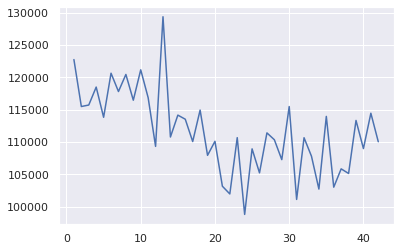

In [127]:
plt.plot(train['y'])

In [128]:
print(revenue_x_m['y'].min())
print(revenue_x_m['y'].mean())
print(revenue_x_m['y'].median())
print(revenue_x_m['y'].std())
print(revenue_x_m['y'].max())

98779.56000000001
113050.54488888892
110767.21
10669.198671933797
166835.02000000005


# Simple Model

In [171]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=3, freq='m')
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [163]:
  predict = forecast[(forecast['ds'] >= '2019-07-30') & (forecast['ds'] <= '2019-11-30')]
  predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
40,2019-07-31,109410.610319,110555.210081,114874.402500,109410.610319,109410.610319,3365.145216,3365.145216,3365.145216,3365.145216,3365.145216,3365.145216,0.0,0.0,0.0,112775.755535
41,2019-08-31,109456.367478,110280.301106,114329.895510,109456.367478,109456.367478,2893.830156,2893.830156,2893.830156,2893.830156,2893.830156,2893.830156,0.0,0.0,0.0,112350.197635
42,2019-09-30,109500.648601,96896.521690,101207.981853,109457.417249,109554.114487,-10385.043280,-10385.043280,-10385.043280,-10385.043280,-10385.043280,-10385.043280,0.0,0.0,0.0,99115.605320
43,2019-10-31,109546.405760,109816.662243,113808.095854,109384.942722,109747.076139,2240.235536,2240.235536,2240.235536,2240.235536,2240.235536,2240.235536,0.0,0.0,0.0,111786.641296
44,2019-11-30,109590.686882,106641.274883,111065.139750,109235.885340,110025.776722,-647.408234,-647.408234,-647.408234,-647.408234,-647.408234,-647.408234,0.0,0.0,0.0,108943.278648


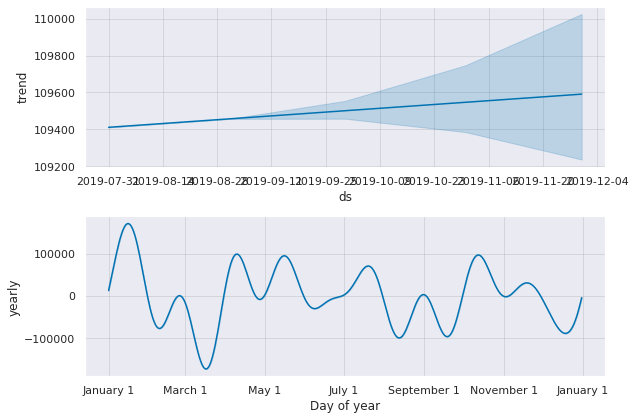

In [164]:
fig_decompose = m.plot_components(predict)

In [165]:
compare_dates('2019-09-30', '2019-11-30', forecast, test)

,ds,y,yhat
0,2019-09-30,102553.42,99115.605320
1,2019-10-31,166835.02,111786.641296
2,2019-11-30,127871.36,108943.278648


# Fourier Model order 5

In [142]:
print(train.shape)
print(test.shape)
test

(42, 2)
(3, 2)


,ds,y
43,2019-09-30,102553.42
44,2019-10-31,166835.02
45,2019-11-30,127871.36


In [175]:
m = Prophet(
    weekly_seasonality=False, 
    daily_seasonality=False, 
    n_changepoints=2)
m.add_seasonality(
    name='monthly', 
    period=12, 
    fourier_order=10)
m.fit(train)

In [0]:
future = m.make_future_dataframe(periods=3, freq='M')
forecast1 = m.predict(future)

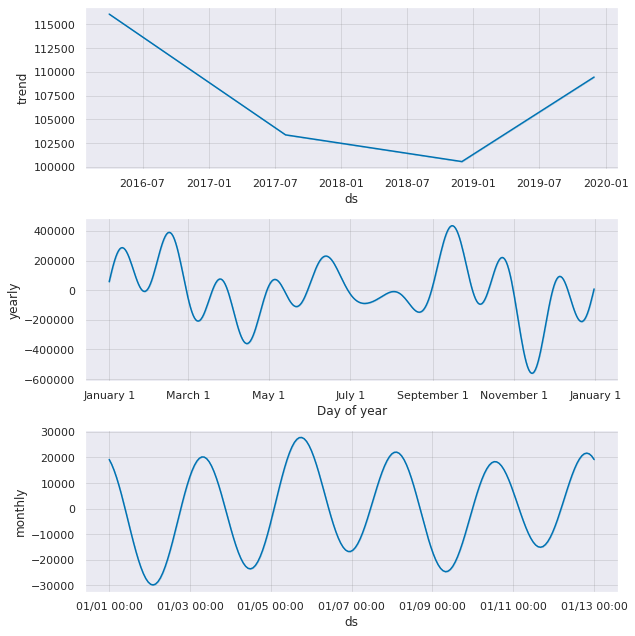

In [155]:
fig_decompose = m.plot_components(forecast1)

In [177]:
compare_dates('2019-09-30', '2019-11-30', forecast1, test)

,ds,y,yhat
0,2019-09-30,102553.42,136084.122387
1,2019-10-31,166835.02,116898.848225
2,2019-11-30,127871.36,115342.361705


# Model with Holidays

In [167]:
print(train.shape)
print(test.shape)
test

(42, 2)
(3, 2)


,ds,y
43,2019-09-30,102553.42
44,2019-10-31,166835.02
45,2019-11-30,127871.36


In [170]:
df_holidays = get_df_holidays([2016,2017,2018,2019])
m = Prophet(holidays=df_holidays,daily_seasonality=True)
m.add_country_holidays(country_name='US')
m.fit(train)
future = m.make_future_dataframe(periods=3, freq='m')
forecast2 = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


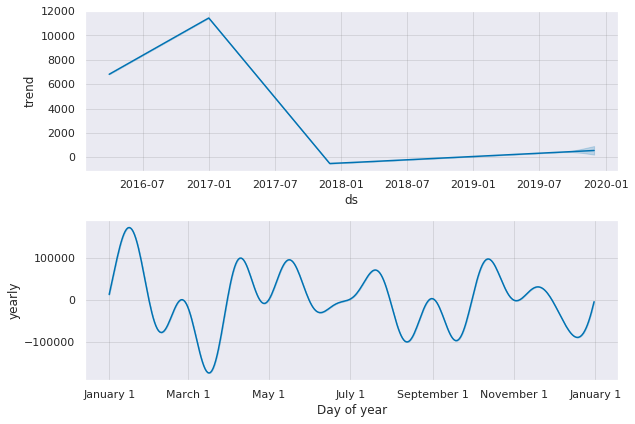

In [172]:
fig_decompose = m.plot_components(forecast2)

In [173]:
compare_dates('2019-09-30', '2019-11-30', forecast2, test)

,ds,y,yhat
0,2019-09-30,102553.42,99115.012065
1,2019-10-31,166835.02,111785.519627
2,2019-11-30,127871.36,108942.529706


# Compare Models

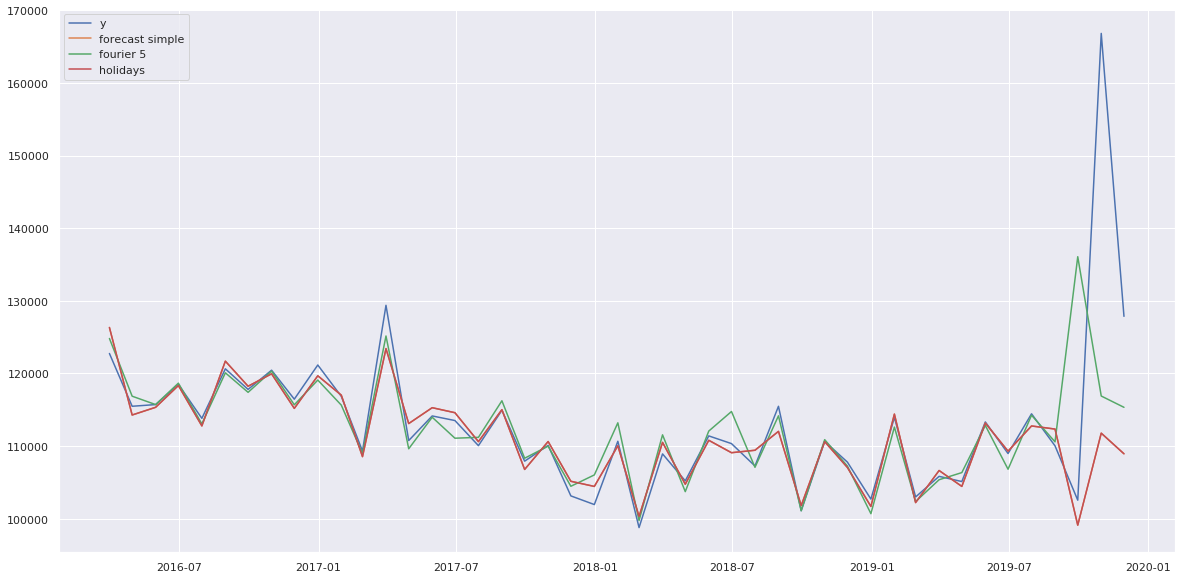

In [178]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(revenue_x_m['ds'], revenue_x_m['y'], label='y')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast simple')
plt.plot(forecast1['ds'], forecast1['yhat'], label='fourier 5')
plt.plot(forecast2['ds'], forecast2['yhat'], label='holidays')
plt.legend(loc="upper left")